### Things to try
- Look at a multioutput model where the gradient is updated only for the branch in question (one at a time)
    - Maybe something like this https://discuss.pytorch.org/t/different-backwards-through-different-branches/152100
- ALSO, look at a model that takes the outputs from the previous model (1 ch in, 9 ch out) and refines the results to be closer to original
    - This seems cool :)
    - Trying one segment at a time
    - Also need to try 9 channel 2d image to maybe add learning from each other?

### Import Libraries

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim

from importlib import reload
import visualization

# locals
import model_architectures

reload(model_architectures)
from model_architectures import VAESegment, Data3DSegT2, SegMaskData, ResnetEncoder, ResnetEncoderHalf, ResnetDecoder

reload(visualization)
from visualization import brain_diff, viz_slices

### Define Paths

In [57]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

### Load Data

In [58]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])

In [59]:
train = Data3DSegT2(l1_dir, l1_seg_vol_dir, train_indices)
val = Data3DSegT2(l1_dir, l1_seg_vol_dir, val_indices)
test = Data3DSegT2(l5_dir, l5_seg_vol_dir, test_indices)

train_segments = SegMaskData(l1_seg_dir, train_indices)
val_segments = SegMaskData(l1_seg_dir, val_indices)
test_segments = SegMaskData(l5_seg_dir, test_indices)

batch_size = 1
train_loader = DataLoader(train, batch_size=batch_size)#, num_workers=1)
val_loader = DataLoader(val, batch_size=batch_size)#, num_workers=1)

### Run Mega Segmented Model

In [61]:
class VariationalLatentMini(nn.Module):
    def __init__(self):
        super().__init__()
        
         
        self.flatten = nn.Flatten()
        self.norm1 = nn.InstanceNorm1d(256)
        self.norm2 = nn.InstanceNorm1d(256)
        self.mu = nn.Linear(256, 128)
        self.sigma = nn.Linear(256, 128)
        
        
        
        self.dense_out = nn.Linear(128, 256)
        self.unflatten = nn.Unflatten(-1, (32, 2, 2, 2))
    
    def forward(self, x):
        x = self.flatten(x)
        
        mu = self.norm1(x)
        mu = self.mu(mu)
        
        sigma = self.norm2(x)
        sigma = self.sigma(sigma)
        
        std = torch.exp(sigma / 2)
        z = mu + std * torch.randn_like(std)
        
        x = self.dense_out((mu + sigma) / 2)
        x = self.unflatten(x)
        return x

class UpConv3d(nn.Module):
    def __init__(self, ch_in, ch_out, k_size=1, stride=2, scale=4, align_corners=False):
        super(UpConv3d, self).__init__()
        self.up = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size=k_size, stride = stride, padding=1),
            nn.Upsample(scale_factor=scale, mode='trilinear', align_corners=align_corners),
            # nn.Upsample(scale_factor=scale, mode='nearest'),
        )
    def forward(self, x):
        return self.up(x)


class MegaVAE(nn.Module):
    def __init__(self, channels):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ResnetEncoder(channels),
            ResnetEncoder(32),
            ResnetEncoder(32),
            ResnetEncoderHalf(32)
        )
        
        self.latent1 = VariationalLatentMini()
        self.latent2 = VariationalLatentMini()
        self.decoder1 = nn.Sequential(
            nn.InstanceNorm3d(32),
            nn.ReLU(),
            UpConv3d(32, 32, k_size=1, stride=1, scale=4),
            nn.InstanceNorm3d(32),
            nn.ReLU(),
            UpConv3d(32, 32, k_size=3, stride=1, scale=4),
            nn.InstanceNorm3d(32),
            nn.ReLU(),
            UpConv3d(32, 32, k_size=3, stride=1, scale=4),
            nn.ConvTranspose3d(32, channels, 1)
        )
        self.decoder2 = nn.Sequential(
            nn.InstanceNorm3d(32),
            nn.ReLU(),
            UpConv3d(32, 32, k_size=1, stride=1, scale=4),
            nn.InstanceNorm3d(32),
            nn.ReLU(),
            UpConv3d(32, 32, k_size=3, stride=1, scale=4),
            nn.InstanceNorm3d(32),
            nn.ReLU(),
            UpConv3d(32, 32, k_size=3, stride=1, scale=4),
            nn.ConvTranspose3d(32, channels, 1)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        l1 = self.latent1(x)
        d1 = self.decoder1(l1)
        
        # l2 = self.latent1(x)
        # d2 = self.decoder1(l2)
        return d1


In [79]:
model = MegaVAE(1)

# model = nn.DataParallel(model)
model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
# this works for batch size of 128, c=1
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            # clear gradients
            optimizer.zero_grad()
            
            # forward
            x, y = data
            x = x.cuda()
            y = y[:,2,:,:,:].reshape((1, 1, 256, 256, 256))
            y = y.cuda()
            output = model(x)
            loss = criterion(y, output)
            
            # backward
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data
            data_counter += 1
#         ## This is probably more memory efficient but doesn't appear necessary in this case
#         # del x
#         # del output
#         # torch.cuda.empty_cache()
        
        total_loss /= data_counter
            
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
#         model.eval()
#         data_counter = 0
#         for data in val_loader:
#             with torch.no_grad():
#                 x, y = data
#                 x = x.cuda()
#                 y = y.cuda()
#                 output = model(x)
#                 loss = criterion(y, output)

#                 val_loss += loss.data
#                 data_counter += 1
        
#         val_loss /= data_counter
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=============================================================================| 166/166 [01:53<00:00,  1.46batch/s]


epoch [1/100], train_loss:0.3181, val_loss:0.0000


100%|=============================================================================| 166/166 [01:56<00:00,  1.42batch/s]


epoch [2/100], train_loss:0.0070, val_loss:0.0000


100%|=============================================================================| 166/166 [01:56<00:00,  1.43batch/s]


epoch [3/100], train_loss:0.0062, val_loss:0.0000


100%|=============================================================================| 166/166 [01:58<00:00,  1.40batch/s]


epoch [4/100], train_loss:0.0059, val_loss:0.0000


100%|=============================================================================| 166/166 [01:58<00:00,  1.40batch/s]


epoch [5/100], train_loss:0.0057, val_loss:0.0000


100%|=============================================================================| 166/166 [01:57<00:00,  1.41batch/s]


epoch [6/100], train_loss:0.0055, val_loss:0.0000


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [7/100], train_loss:0.0055, val_loss:0.0000


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [8/100], train_loss:0.0053, val_loss:0.0000


100%|=============================================================================| 166/166 [01:58<00:00,  1.40batch/s]


epoch [9/100], train_loss:0.0055, val_loss:0.0000


  2%|=>                                                                             | 4/166 [00:03<02:14,  1.21batch/s]


KeyboardInterrupt: 

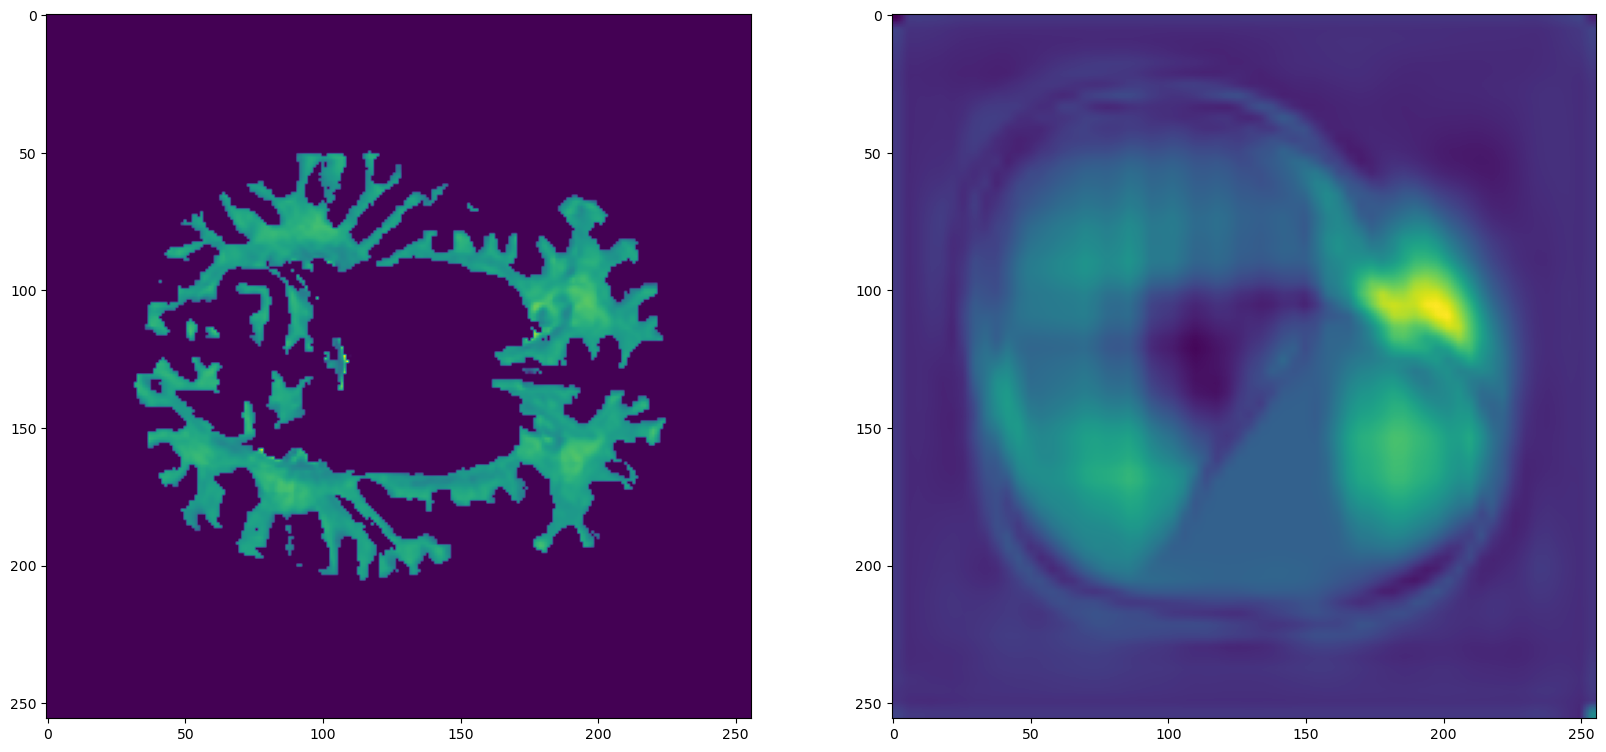

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(y.cpu().reshape((256, 256, 256)).numpy()[:,:,128])
ax[1].imshow(output.detach().cpu().reshape((256, 256, 256)).numpy()[:,:,128])

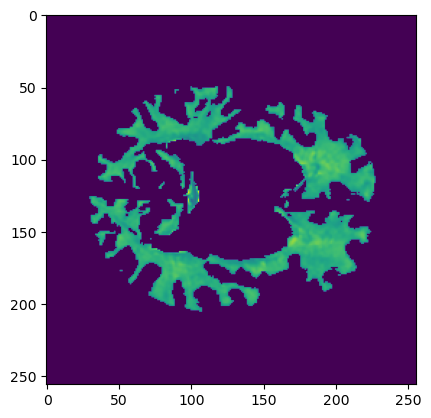

In [78]:
plt.imshow(data[1][:,2,:,:,:].reshape((256, 256, 256)).numpy()[:,:,128])

In [56]:
model = MegaVAE(1)
summary(model.cuda(), (1, 256, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    InstanceNorm3d-1     [-1, 1, 256, 256, 256]               0
              ReLU-2     [-1, 1, 256, 256, 256]               0
            Conv3d-3    [-1, 32, 128, 128, 128]             896
    InstanceNorm3d-4    [-1, 32, 128, 128, 128]               0
              ReLU-5    [-1, 32, 128, 128, 128]               0
            Conv3d-6       [-1, 32, 64, 64, 64]          27,680
            Conv3d-7       [-1, 32, 64, 64, 64]             896
              ReLU-8       [-1, 32, 64, 64, 64]               0
     ResnetEncoder-9       [-1, 32, 64, 64, 64]               0
   InstanceNorm3d-10       [-1, 32, 64, 64, 64]               0
             ReLU-11       [-1, 32, 64, 64, 64]               0
           Conv3d-12       [-1, 32, 32, 32, 32]          27,680
   InstanceNorm3d-13       [-1, 32, 32, 32, 32]               0
             ReLU-14       [-1, 32, 32,